# Lab — Binary Classification and Logistic Models

In this first lab, we explore binary. We gradually move from simple Gaussian mixture models to logistic regression, polynomial feature expansion, ROC analysis, and finally a home-made implementation of logistic regression.

**Objectives:**
- Understand the Bayes classifier in the Gaussian mixture model.
- Implement and visualize the Bayes decision boundary.
- Build a Linear Discriminant Analysis (LDA) classifier.
- Compare LDA to logistic regression.
- Enrich logistic regression with polynomial features.
- Evaluate models using ROC curves and AUC.
- Implement logistic regression *from scratch* with gradient descent.


## 1. Gaussian Mixture and Bayes Classifier

We begin with a simple synthetic binary classification problem:
a **mixture of two Gaussians** with equal covariance matrix.  
In this setting, the **Bayes classifier** is known in closed form and is itself a *linear* classifier.

### Task
1. Implement a class that computes the Bayes decision rule.
2. Display the decision boundary, and experiment with several values of `p` and `rho` (correlation).

The function below will perform the plotting for you.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def sigmoid(z): 
    return 1/(1+np.exp(-z))


class BayesClassifier:
    def __init__(self, p, mu0, mu1, rho):
        self.p = float(p)
        self.mu0 = np.asarray(mu0)
        self.mu1 = np.asarray(mu1)
        Sigma = np.array([[1, rho], [rho, 1]])
        S_inv = np.linalg.inv(Sigma)
        
        # direction vector
        self.w = S_inv @ (self.mu0 - self.mu1)
        
        # bias term
        t1 = self.mu1 @ S_inv @ self.mu1
        t0 = self.mu0 @ S_inv @ self.mu0
        self.b = 0.5*(t0 - t1) + np.log(self.p/(1 - self.p))


    def decision_function(self, X):
        """Return the linear score w^T x + b."""
        return X @ self.w + self.b
        

    def predict_proba(self, X):
        s = self.decision_function(X)
        p1 = sigmoid(s)
        return np.c_[1 - p1, p1]

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)



In [20]:
def plot_mixture_and_bayes(p, mu0, mu1, rho):
    mu0, mu1 = map(np.asarray, (mu0, mu1))
    Sigma = np.array([[1, rho], [rho, 1]])
    clf = BayesClassifier(p, mu0, mu1, rho)

    # Grid (auto-sized if samples provided)
    x_min, x_max, y_min, y_max = -4, 4, -4, 4

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    G = np.c_[xx.ravel(), yy.ravel()]

    # Gaussian mixture
    f0 = multivariate_normal(mu0, Sigma).pdf(G)
    f1 = multivariate_normal(mu1, Sigma).pdf(G)
    Z = ((1-p)*f0 + p*f1).reshape(xx.shape)

    # Bayes boundary
    post = clf.predict_proba(G)[:,1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, levels=20, cmap="viridis")
    plt.contour(xx, yy, Z, colors="k", linewidths=0.4)
    plt.contour(xx, yy, post, levels=[0.5], colors='red', linewidths=2)

    plt.gca().set_aspect("equal")
    plt.title(f"Mixture level sets + Bayes boundary (p={p}, rho={rho})")
    plt.show()


### Example: Visualizing the Bayes classifier

We now visualize two scenarios:
- balanced and uncorrelated mixture,
- unbalanced and correlated mixture.

Observe how the Bayes boundary changes.


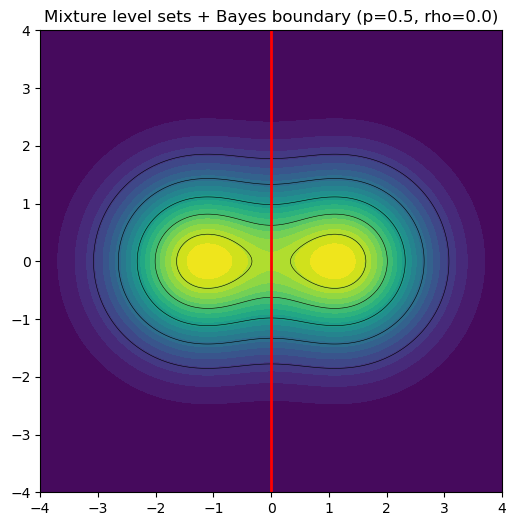

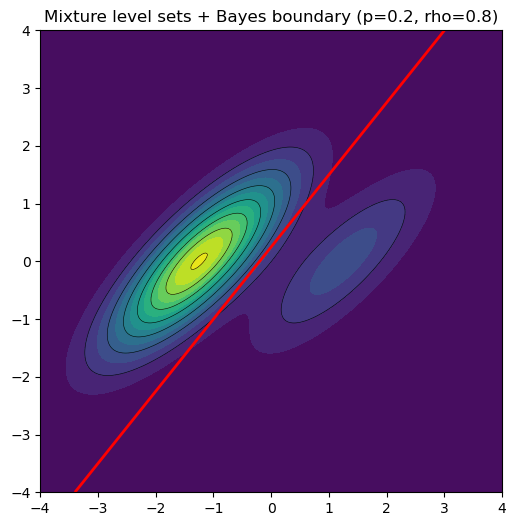

In [21]:
plot_mixture_and_bayes(
    p=0.5, 
    mu0=[-1.25, 0], 
    mu1=[+1.25, 0], 
    rho=0.0
)

# Now your turn, with unbalanced and correlated features

plot_mixture_and_bayes(
    p=0.2, 
    mu0=[-1.25, 0], 
    mu1=[1.25, 0], 
    rho=0.8
)


## 2. Generating Data From a Gaussian Mixture

We now generate labeled samples from  
\[
(1-p)\, \mathcal N(\mu_0, \Sigma) \quad \text{and} \quad
p\, \mathcal N(\mu_1, \Sigma),
\]
and we will train classifiers on this data.

### Task
- Understand the `generate_mixture_samples` function.
- Generate datasets for multiple parameter choices.


In [8]:
def generate_mixture_samples(n, p, mu0, mu1, rho, random_state=None):
    """
    Generate n samples from the 2D Gaussian mixture:
        (1-p) N(mu0, Sigma) + p N(mu1, Sigma)
    with Sigma = [[1, rho], [rho, 1]].
    Returns X (n,2) and y (n,) in {0,1}.
    """
    rng = np.random.default_rng(random_state)
    mu0, mu1 = np.asarray(mu0), np.asarray(mu1)
    Sigma = np.array([[1, rho], [rho, 1]])
    
    # sample class labels
    y = rng.binomial(1, p, size=n)
    
    # sample from multivariate normal according to classes
    X = np.zeros((n, 2))
    idx1 = (y == 1)
    idx0 = ~idx1
    
    if idx0.any():
        X[idx0] = multivariate_normal(mu0, Sigma).rvs(size=idx0.sum(), random_state=rng)
    if idx1.any():
        X[idx1] = multivariate_normal(mu1, Sigma).rvs(size=idx1.sum(), random_state=rng)
    
    return X, y


### Visualizing the sampled dataset

We now generate 500 samples and visualize the resulting clusters.
This will serve as our training data for LDA and logistic regression later on.


In [10]:
p   = 0.5
mu0 = [-1.25, 0]
mu1 = [ 1.25, 0]
rho = 0.0

# Your code here


## 3. Linear Discriminant Analysis (LDA)

LDA is a **generative binary classifier** based on the assumption:

- both classes are Gaussian,
- with the **same covariance matrix** but different means.

Under these assumptions, the Bayes classifier is linear and can be estimated from data.

### Task
- Complete the LDA classifier below.
- Understand how `mu0`, `mu1`, and the shared covariance are estimated.


In [11]:
class LDAClassifier:
    def fit(self, X, y):
        X, y = np.asarray(X, float), np.asarray(y, int)
        X0, X1 = X[y == 0], X[y == 1]
        n0, n1 = len(X0), len(X1)
        self.p_ = n1 / (n0 + n1)
        
        # 1. Estimation des moyennes des classes
        self.mu0_ = X0.mean(axis=0)
        self.mu1_ = X1.mean(axis=0)
        
        # 2. Estimation de la covariance commune (pooled covariance)
        # On calcule les matrices de covariance de chaque classe et on fait la moyenne pondérée
        S0 = np.cov(X0, rowvar=False, bias=True)
        S1 = np.cov(X1, rowvar=False, bias=True)
        S = (n0 * S0 + n1 * S1) / (n0 + n1)
        S_inv = np.linalg.inv(S)
        
        # 3. Paramètres du modèle linéaire : w^T x + b
        # La formule vient du log-ratio des densités gaussiennes
        self.w_ = S_inv @ (self.mu1_ - self.mu0_)
        
        t1 = self.mu1_ @ S_inv @ self.mu1_
        t0 = self.mu0_ @ S_inv @ self.mu0_
        self.b_ = -0.5 * t1 + 0.5 * t0 + np.log(self.p_ / (1 - self.p_))

        return self

    def decision_function(self, X):
        return X @ self.w_ + self.b_

    def predict_proba(self, X):
        s = self.decision_function(X)
        p1 = sigmoid(s)
        return np.c_[1 - p1, p1]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(int)

### Training and Evaluating LDA

We split the dataset into **training** and **test** sets.

### Task
- Train LDA using the training set.
- Evaluate prediction accuracy on the test set. 
- Print predicted probabilities for a few examples.
- Understand the structure of the predicted probabilities


In [13]:
# --- generate data from mixture ---
p   = 0.5
mu0 = [-1.25, 0]
mu1 = [ 1.25, 0]
rho = 0.3

X, y = generate_mixture_samples(500, p, mu0, mu1, rho, random_state=0)

# --- train/test split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# --- fit LDA ---
lda = LDAClassifier()
lda.fit(X_train,y_train)

# --- predict on first 5 test points ---
print("Test points:\n", X_test[:5])
print("True labels :", y_test[:5])
print("Predicted   :", lda.predict(X_test[:5]))
print("Predict proba:\n", lda.predict_proba(X_test[:5]))


Test points:
 [[ 1.14043505 -0.47432458]
 [-2.17615179  0.05386393]
 [-0.58474358  2.10801622]
 [ 1.58569423  0.68637463]
 [-1.88289474 -0.63697667]]
True labels : [1 0 0 1 0]
Predicted   : [1 0 0 1 0]
Predict proba:
 [[0.02028964 0.97971036]
 [0.9977942  0.0022058 ]
 [0.93372802 0.06627198]
 [0.01086568 0.98913432]
 [0.99231715 0.00768285]]


### Comparing LDA and Bayes Boundaries

Here we compare the decision boundaries:
- **LDA** (estimated from finite data)
- **Bayes** (the true optimal classifier)

### Question
- When do you expect LDA to match the Bayes classifier?
- What happens when the sample size is small?


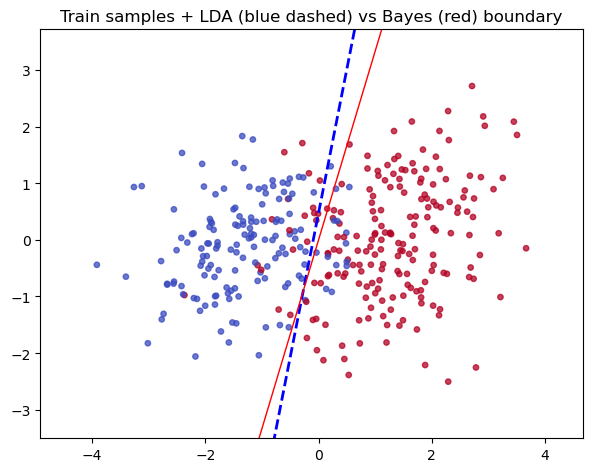

In [22]:
bayes = BayesClassifier(p, mu0, mu1, rho)

# --- grid (based on train set) ---
x_min, x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
y_min, y_max = X_train[:,1].min()-1, X_train[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
G = np.c_[xx.ravel(), yy.ravel()]

post_lda   = lda.predict_proba(G)[:,1].reshape(xx.shape)
post_bayes = bayes.predict_proba(G)[:,1].reshape(xx.shape)

# --- plot ---
plt.figure(figsize=(7,6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="coolwarm",s=15, alpha=0.75)

# LDA boundary (blue)
plt.contour(xx, yy, post_lda, levels=[0.5], colors=["#0000ff"], linewidths=2, linestyles="--")
# Bayes boundary (bright red)
plt.contour(xx, yy, post_bayes, levels=[0.5], colors=["#ff0000"], linewidths=1)

plt.gca().set_aspect("equal")
plt.title("Train samples + LDA (blue dashed) vs Bayes (red) boundary")
plt.show()


Evaluate the accuracy of the LDA classifier on the test set

In [ ]:
# LDA accuracy on test set
y_pred_lda = lda.predict(X_test)
accuracy_lda = np.mean(y_pred_lda == y_test)
print(f"Accuracy LDA on test set: {accuracy_lda * 100:.2f}%")

### Double moons

We now use the double moons dataset, whose classes are clearly non-Gaussian.
Although LDA’s assumptions do not hold here, we can still train it and observe the resulting decision boundary and compare it with logistic regression.


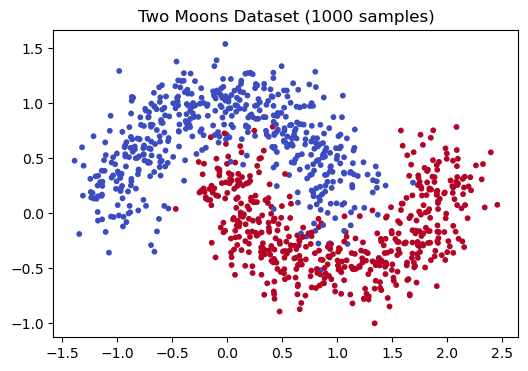

In [23]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# generate data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)

# scatter plot
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=10)
plt.gca().set_aspect("equal")
plt.title("Two Moons Dataset (1000 samples)")
plt.show()


In [27]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=0)

# fit LDA
lda = LDAClassifier()
lda.fit(X_train,y_train)

# accuracy on test set
y_pred_lda = lda.predict(X_test)
accuracy = np.mean(y_pred_lda == y_test)
print(f"Accuracy LDA sur Double Moons : {accuracy * 100:.2f}%")


Accuracy LDA sur Double Moons : 85.00%


Now let us visualize the decision boundary

In [28]:
def plot_points_and_boundary(clf, X, y, title="Decision boundary"):
    X, y = np.asarray(X), np.asarray(y)

    # grid around data
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    G = np.c_[xx.ravel(), yy.ravel()]

    # posterior for class 1 (assuming sklearn-style predict_proba)
    post = clf.predict_proba(G)[:,1].reshape(xx.shape)

    # plot
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm",
                s=12, alpha=0.7)
    plt.contour(xx, yy, post, levels=[0.5], colors=["#0000ff"], linewidths=2)

    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.show()


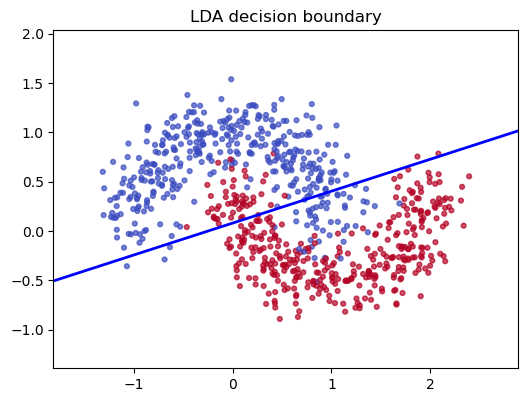

In [29]:
plot_points_and_boundary(lda, X_train, y_train, title="LDA decision boundary")


## 4. Logistic Regression

We now switch to a **discriminative** model: logistic regression.

### Objectives
- Fit a logistic classifier to the mixture data.
- Compare its decision boundary with LDA and Bayes.
- Explore improvements using **polynomial feature expansion**.


Logistic Regression accuracy on test set: 85.50%


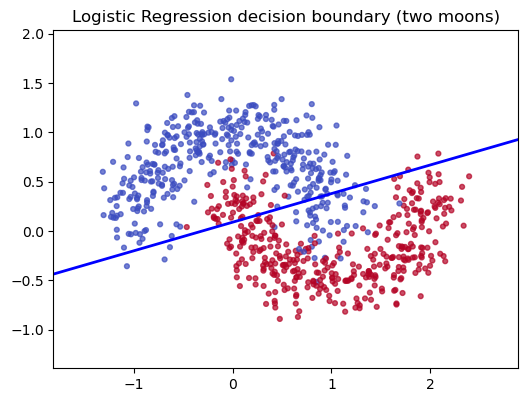

In [30]:
from sklearn.linear_model import LogisticRegression

# --- fit Logistic Regression ---
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

# --- accuracy ---
lr.fit(X_train, y_train)
accuracy_lr = lr.score(X_test, y_test)
print(f"Logistic Regression accuracy on test set: {accuracy_lr * 100:.2f}%")

# --- display decision boundary ---
plot_points_and_boundary(lr, X_train, y_train,
title="Logistic Regression decision boundary (two moons)")


Polynomial Logistic Regression (degree 3) accuracy on test set: 97.00%


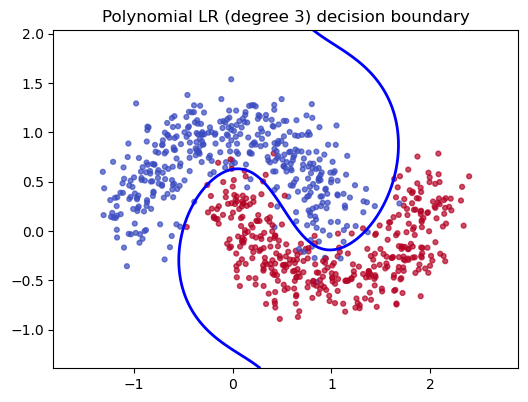

In [31]:
from sklearn.preprocessing import PolynomialFeatures

k = 3  # polynomial degree

# --- polynomial transform ---
poly = PolynomialFeatures(k, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

# --- fit LR on polynomial features ---
lr_poly = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)
lr_poly.fit(X_train_poly, y_train)

# --- accuracy ---
accuracy_poly = lr_poly.score(X_test_poly, y_test)
print(f"Polynomial Logistic Regression (degree {k}) accuracy on test set: {accuracy_poly * 100:.2f}%")

# --- decision boundary plot (on original X grid) ---
# we wrap clf so plot_points_and_boundary can call predict_proba on raw X

class PolyWrapper:
    def __init__(self, poly, clf):
        self.poly = poly
        self.clf = clf
    def predict_proba(self, X):
        return self.clf.predict_proba(self.poly.transform(X))

plot_points_and_boundary(
    PolyWrapper(poly, lr_poly),
    X_train,
    y_train,
    title=f"Polynomial LR (degree {k}) decision boundary"

)

### Task: Increase the polynomial degree

Increase the value of \(k\) in the polynomial features and observe how the decision boundary evolves.  
To clearly see the effect **without regularization**, do **not** use the default scikit-learn setting.  
Instead, set: C = 1e9, so that regularization is essentially removed.  
Discuss what happens as \(k\) becomes large.

Degree 1: test accuracy = 85.50%


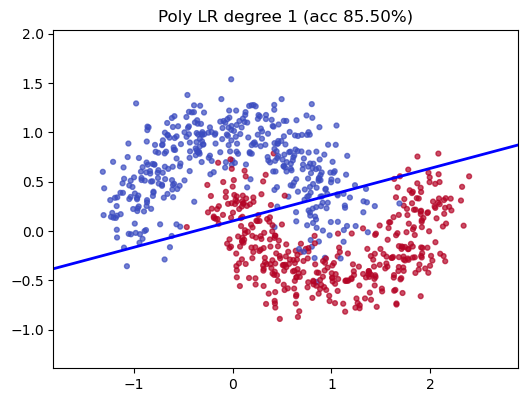

Degree 3: test accuracy = 97.00%


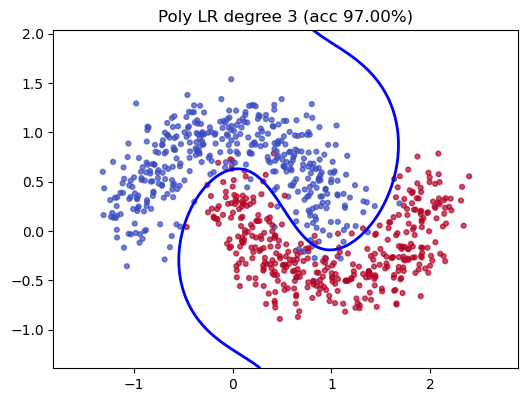

Degree 5: test accuracy = 96.50%


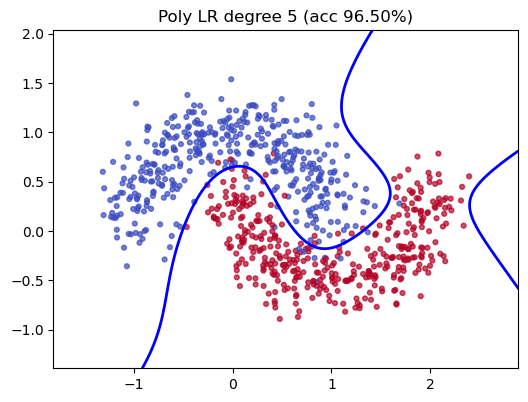

Degree 7: test accuracy = 97.00%


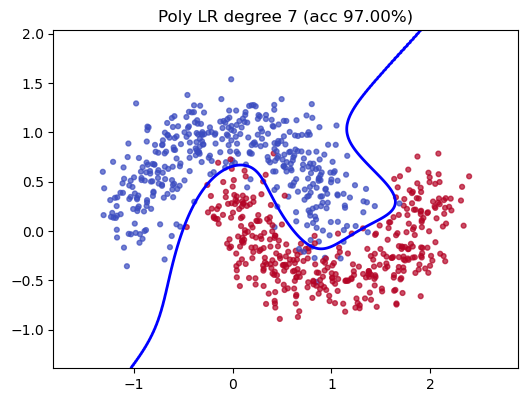

Degree 9: test accuracy = 97.00%


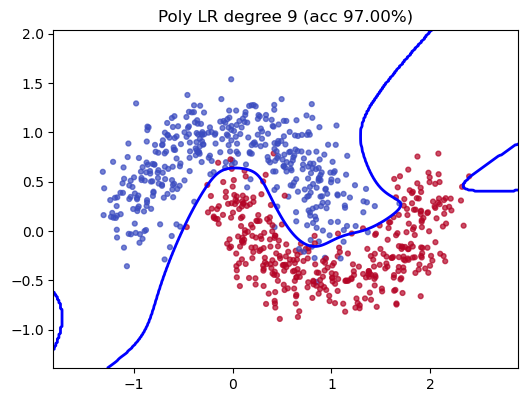

In [32]:
# Explore how increasing polynomial degree affects fit and overfitting
degrees = [1, 3, 5, 7, 9]
for k_deg in degrees:
    poly_k = PolynomialFeatures(k_deg, include_bias=False)
    X_train_k = poly_k.fit_transform(X_train)
    X_test_k = poly_k.transform(X_test)

    # Fit logistic regression with negligible regularization
    lr_k = LogisticRegression(C=1e9, solver='lbfgs', max_iter=2000)
    lr_k.fit(X_train_k, y_train)

    acc = lr_k.score(X_test_k, y_test)
    print(f"Degree {k_deg}: test accuracy = {acc * 100:.2f}%")

    # Plot decision boundary on original feature space
    plot_points_and_boundary(PolyWrapper(poly_k, lr_k), X_train, y_train,
                             title=f"Poly LR degree {k_deg} (acc {acc * 100:.2f}%)")

# Note: Larger degrees increase model flexibility and can cause overfitting or numerical instability.


## 5. ROC Curves and AUC

Accuracy alone is often insufficient.  
We now compare models using **ROC curves** and the **Area Under the Curve (AUC)**.

### Models compared:
- LDA
- Logistic regression
- Logistic regression with polynomial features (degree 3)

### Task
- Generate ROC curves for the three models.
- Compare their AUCs.
- Comment on which model is best and why.


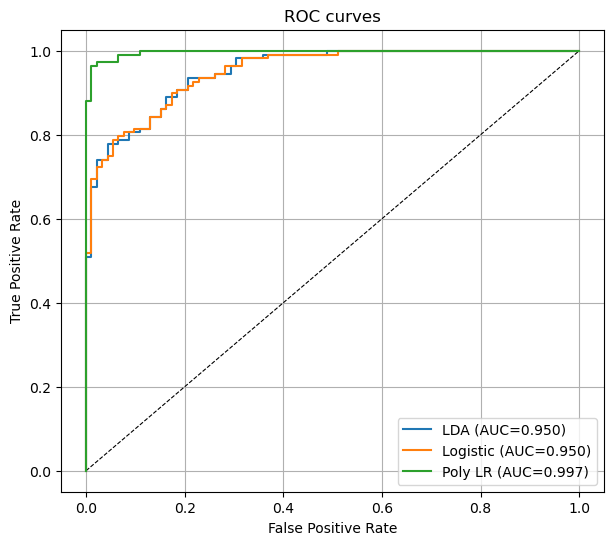

AUC LDA: 0.950
AUC Logistic Regression: 0.950
AUC Polynomial Logistic Regression (degree 3): 0.997


In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

# predicted scores
y_score_lda = lda.predict_proba(X_test)[:, 1]
y_score_lr = lr.predict_proba(X_test)[:, 1]
y_score_lr_poly = lr_poly.predict_proba(X_test_poly)[:, 1]

# ROC curves
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_score_lda)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_poly, tpr_poly, _ = roc_curve(y_test, y_score_lr_poly)

# AUCs
auc_lda = roc_auc_score(y_test, y_score_lda)
auc_lr = roc_auc_score(y_test, y_score_lr)
auc_poly = roc_auc_score(y_test, y_score_lr_poly)

# Plot
plt.figure(figsize=(7, 6))
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
plt.plot(fpr_lda, tpr_lda, label=f"LDA (AUC={auc_lda:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})")
plt.plot(fpr_poly, tpr_poly, label=f"Poly LR (AUC={auc_poly:.3f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC LDA: {auc_lda:.3f}")
print(f"AUC Logistic Regression: {auc_lr:.3f}")
print(f"AUC Polynomial Logistic Regression (degree {k}): {auc_poly:.3f}")

## 6. Implementing Logistic Regression From Scratch

To deepen your understanding, you will build your own logistic regression class.

### Task
- Implement the gradient descent.


In [39]:
import numpy as np

class myLogisticRegression:
    def __init__(self, lr=0.1, max_iter=1000):
        self.lr = lr
        self.max_iter = max_iter
        self.loss_history = []       # <--- NEW

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n, d = X.shape

        # add intercept
        Xb = np.c_[np.ones(n), X]
        self.w = np.zeros(d + 1)

        for _ in range(self.max_iter):
            scores = Xb @ self.w
            p1 = self.sigmoid(scores)

            # Binary cross-entropy loss
            eps = 1e-15
            loss = -np.mean(y * np.log(p1 + eps) + (1 - y) * np.log(1 - p1 + eps))
            self.loss_history.append(loss)

            # Gradient descent
            grad = Xb.T @ (p1 - y) / n
            self.w -= self.lr * grad

        return self
    
    def predict_proba(self, X):
        Xb = np.c_[np.ones(len(X)), X]
        p1 = self.sigmoid(Xb @ self.w)
        return np.c_[1 - p1, p1]
    
    def predict(self, X):
        return (self.predict_proba(X)[:,1] >= 0.5).astype(int)


### Training Loss Curve

We now train our custom logistic model and visualize the **training loss**.

### Question
- Is the loss decreasing monotonically?
- What happens if you use a learning rate that’s too large? too small?


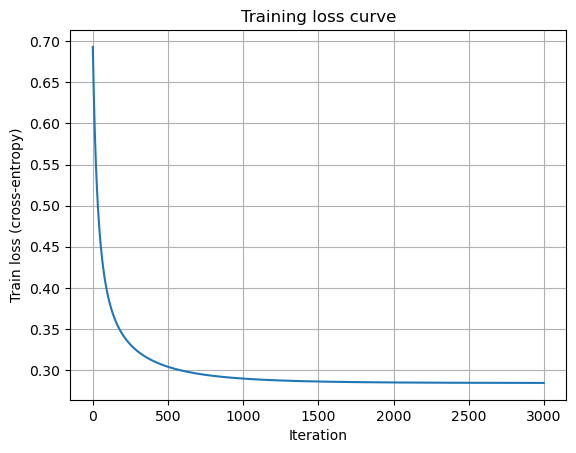

In [40]:
clf = myLogisticRegression(lr=0.1, max_iter=3000)
clf.fit(X_train, y_train)

import matplotlib.pyplot as plt
plt.plot(clf.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Train loss (cross-entropy)")
plt.title("Training loss curve")
plt.grid(True)
plt.show()


Evaluate the accuracy

In [42]:
# Evaluate custom logistic regression accuracy on test set
y_pred_custom = clf.predict(X_test)
accuracy_custom = np.mean(y_pred_custom == y_test)
print(f"Custom logistic regression accuracy on test set: {accuracy_custom * 100:.2f}%")


Custom logistic regression accuracy on test set: 85.50%


### Answers    

- **Is the loss decreasing monotonically?** Not necessarily. With a reasonable learning rate the training loss typically decreases and converges, but it may not be strictly monotonic — small per-iteration fluctuations can occur (numerical effects or batch variance).

- **What happens if the learning rate is too large?** Training can diverge or oscillate: the loss may increase or blow up and the weights become unstable.

- **What happens if the learning rate is too small?** Convergence becomes very slow (many iterations) and training may appear stuck, though it remains stable.